<a href="https://colab.research.google.com/github/francotestori/aauba_02/blob/master/Solution_Developement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Armado del DataFrame

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt

# Encoders & Split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV

#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Scoring & Reporting
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# Librerías plotting
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9, 5]
sns.set_style("darkgrid")

print('Libraries Imported')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Libraries Imported


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits.csv',
    index_col=0
)

df.head()

,ddenergy_mean,ddenergy_std,ddmfcc_0_mean,ddmfcc_0_std,ddmfcc_10_mean,ddmfcc_10_std,ddmfcc_11_mean,ddmfcc_11_std,ddmfcc_1_mean,ddmfcc_1_std,ddmfcc_2_mean,ddmfcc_2_std,ddmfcc_3_mean,ddmfcc_3_std,ddmfcc_4_mean,ddmfcc_4_std,ddmfcc_5_mean,ddmfcc_5_std,ddmfcc_6_mean,ddmfcc_6_std,ddmfcc_7_mean,ddmfcc_7_std,ddmfcc_8_mean,ddmfcc_8_std,ddmfcc_9_mean,ddmfcc_9_std,denergy_mean,denergy_std,digit,dmfcc_0_mean,dmfcc_0_std,dmfcc_10_mean,dmfcc_10_std,dmfcc_11_mean,dmfcc_11_std,dmfcc_1_mean,dmfcc_1_std,dmfcc_2_mean,dmfcc_2_std,dmfcc_3_mean,dmfcc_3_std,dmfcc_4_mean,dmfcc_4_std,dmfcc_5_mean,dmfcc_5_std,dmfcc_6_mean,dmfcc_6_std,dmfcc_7_mean,dmfcc_7_std,dmfcc_8_mean,dmfcc_8_std,dmfcc_9_mean,dmfcc_9_std,energy_mean,energy_std,filename,mfcc_0_mean,mfcc_0_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std
0,-0.000040,0.004047,-0.087577,14.439054,0.289443,8.461383,0.001000,4.527796,-0.276688,10.856913,-0.018697,12.444738,0.172892,11.896126,0.166432,5.956282,0.098696,7.476521,0.007125,7.080504,0.158096,6.999523,0.118771,7.826736,0.112117,7.799444,0.000005,0.007348,zero,0.387241,26.726141,-0.325877,8.762013,-0.017884,4.282867,0.139810,16.173223,0.345507,16.423527,0.282263,14.687464,-0.023132,8.464055,-0.226542,6.998120,-0.206619,6.600952,-0.088103,6.912228,-0.126719,9.370098,-0.140965,7.608357,0.031405,0.030842,speechcommands/zero/8dd788d8_nohash_1.wav,-310.373780,108.335783,-12.138142,19.095641,6.300064,8.229837,108.100260,39.959982,-35.916181,37.495254,33.898475,25.414830,-30.267377,24.366416,21.804664,9.490059,-8.092194,13.301543,3.688589,18.480796,-27.701459,21.117286,14.652777,10.857483
1,-0.000224,0.008262,-0.182528,21.594038,0.008355,5.840726,0.087771,6.301972,-0.118388,10.820153,0.116756,14.593893,0.024313,10.843247,-0.117824,11.666164,-0.197453,7.340812,-0.373940,6.868907,-0.158919,6.697412,-0.172334,8.373859,-0.085276,6.904384,0.000675,0.011127,zero,0.263953,28.657321,0.018793,4.308382,0.322682,6.000490,0.023330,11.932052,-0.045622,17.403189,0.146212,11.297503,0.428317,10.951434,0.323952,7.076900,0.058051,8.351322,0.008589,7.236734,0.045069,7.127188,0.114088,5.511203,0.076727,0.040160,speechcommands/zero/6021f08b_nohash_0.wav,-268.940979,96.166463,0.485951,5.873054,6.682188,7.696213,109.094888,30.126237,18.249464,43.767123,39.821188,17.850829,27.161642,16.963540,26.775130,16.508826,-2.063644,21.946652,13.449217,16.439935,-2.512277,9.671001,17.021364,9.597063
2,0.000331,0.039083,-1.393533,33.512079,0.523177,8.641218,-0.197498,7.290841,0.644651,17.501375,0.133704,10.075938,0.790281,13.438439,-0.305298,11.651066,0.161379,10.441262,-0.072442,8.470837,-0.124640,8.645921,-0.305004,7.428344,-0.251130,9.858792,-0.005057,0.055144,zero,-3.657910,42.929844,0.547587,8.974828,0.520600,5.924756,-3.630059,20.239011,-2.661199,14.608974,-0.664190,14.109088,-0.388859,12.218891,1.116912,9.438793,1.269988,6.818314,0.650308,6.981177,0.046947,7.233902,-0.135616,8.432754,0.284765,0.198115,speechcommands/zero/5aac2efa_nohash_0.wav,-162.838334,152.889283,-5.995101,20.488937,-3.803240,10.556037,89.749041,50.146729,-11.773584,51.632548,-5.650079,30.596622,-21.146136,27.040773,-21.872953,18.821318,-24.375052,14.214723,-16.363518,8.142725,-14.993416,13.274695,-7.609461,10.120220
3,-0.000022,0.010173,-0.647873,21.422757,0.120790,5.620986,0.082528,4.805060,-0.454970,13.847316,0.123681,13.428330,0.245653,12.344635,0.213345,10.397040,0.293587,9.086914,0.509202,10.586381,0.272438,7.377933,0.150039,8.711009,-0.052710,4.734111,0.000012,0.020158,zero,0.175276,36.334235,-0.401118,5.677760,-0.505302,3.918342,1.331990,19.071729,0.421617,19.291494,-1.422872,16.455475,-0.300709,11.134505,0.026611,7.565342,-0.378856,11.856558,-0.196623,7.215757,0.042180,8.890276,0.073596,5.559824,0.072842,0.081364,speechcommands/zero/5236848b_nohash_3.wav,-311.809058,148.300601,-3.725588,10.90823

# Split Train-Test

Para poder splitear nuestros dataframe en tres sets distintos (train, validation y testing) debemos utilizar los archivos provistos en el datasource de speechcommands.

In [3]:
# Armamos nuestras listas de items que deberán formar nuestra partición de validación
validation_list = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_validation.csv',
    index_col=0
)

# Armamos nuestras listas de items que deberán formar nuestra partición de testing
testing_list = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_testing.csv',
    index_col=0
)

In [4]:
# Evaluamos los valores de las columnas del dataframe
df.columns

# Generamos una nueva columna 'audio_name' que normaliza el nombre del audio referenciado
df['audio_name'] = df['filename'].str.slice(start=15)

In [5]:
# Evaluamos ahora a que split pertenece cada audio y lo marcamos en el dataframe
tipo_split = []

for i in df['audio_name'] :
  if i in testing_list.index.to_list():
    tipo_split.append('test')
  elif i in validation_list.index.to_list():
    tipo_split.append('validation') 
  else:
    tipo_split.append('training')

df['split'] = tipo_split

df['split'].value_counts()

training      18620
test           2552
validation     2494
Name: split, dtype: int64

In [6]:
# Finalmente armamos nuestros conjuntos

df_test = df[df['split']=='test']
df_val = df[df['split']=='validation']
df_train = df[df['split']=='training']

# Target
y_train = df_train['digit']
y_val = df_val['digit']
y_test = df_test['digit']

# Features
x_train = df_train.drop(['digit','filename','audio_name','split'],axis=1)
x_val = df_val.drop(['digit','filename','audio_name','split'],axis=1)
x_test = df_test.drop(['digit','filename','audio_name','split'],axis=1)

print(f'Entrenamiento: {len(x_train)}')
print('Validacion: {}'.format(len(x_val)))
print(f'Held-out: {len(x_test)}')

Entrenamiento: 18620
Validacion: 2494
Held-out: 2552


In [7]:
# Estandarizamos nuestros datos
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_val_scaled = pd.DataFrame(scaler.fit_transform(x_val))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [8]:
# Chequeamos la consistencia de nuestros targets de entrenamiento
pd.Series(y_train).unique()

array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
       'eight', 'nine'], dtype=object)

In [ ]:
for k,title in enumerate(pd.Series(y_train).unique()):
    print(f'Y >  {title}', end='\t')
    perc_train = pd.Series(y_train).value_counts(normalize=True)
    perc_val = pd.Series(y_val).value_counts(normalize=True)
    perc_test = pd.Series(y_test).value_counts(normalize=True)
    print(f'Entrenamiento:{perc_train[k]:.5}', end='\t')
    print(f'Validación:{perc_val[k]:.5}', end='\t')
    print(f'Held-out:{perc_train[k]:.5}')

Y >  zero	Entrenamiento:0.10161	Validación:0.11227	Held-out:0.10161
Y >  one	Entrenamiento:0.1007	Validación:0.10545	Held-out:0.1007
Y >  two	Entrenamiento:0.1007	Validación:0.10505	Held-out:0.1007
Y >  three	Entrenamiento:0.10059	Validación:0.10425	Held-out:0.10059
Y >  four	Entrenamiento:0.10021	Validación:0.099439	Held-out:0.10021
Y >  five	Entrenamiento:0.10005	Validación:0.097434	Held-out:0.10005
Y >  six	Entrenamiento:0.099463	Validación:0.097033	Held-out:0.099463
Y >  seven	Entrenamiento:0.099033	Validación:0.094627	Held-out:0.099033
Y >  eight	Entrenamiento:0.098872	Validación:0.092221	Held-out:0.098872
Y >  nine	Entrenamiento:0.098765	Validación:0.092221	Held-out:0.098765


# Naive Bayes

## Preprocessing

In [9]:
# Como no hay validación, se juntan train y val para entrenar al modelo.

## Versión estandarizada
x_train_nb_scaled = x_train_scaled.append(x_val_scaled, ignore_index=True)

## Versión sin estandarizado
x_train_nb = x_train.append(x_val, ignore_index=True)

## Target
y_train_nb = y_train.append(y_val, ignore_index=True)

## No Scale

In [10]:
gnb = GaussianNB()
gnb.fit(x_train_nb, y_train_nb)
gnb_y_pred = gnb.predict(x_test)

In [ ]:
print(gnb.classes_)

['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [ ]:
print(gnb.get_params())

{'priors': None, 'var_smoothing': 1e-09}


In [ ]:
# Mean of each feature per class
print(gnb.theta_)

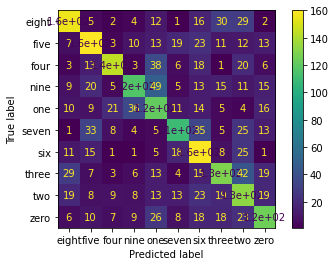

In [ ]:
# Confusion Matrix
plot_confusion_matrix(gnb, x_test, y_test)

In [ ]:
# Classification Report
gnb_report = classification_report(y_test,gnb_y_pred)
print(gnb_report)

              precision    recall  f1-score   support

       eight       0.62      0.61      0.61       257
        five       0.57      0.59      0.58       271
        four       0.71      0.57      0.63       253
        nine       0.59      0.45      0.51       259
         one       0.41      0.49      0.45       248
       seven       0.56      0.46      0.51       239
         six       0.48      0.65      0.55       244
       three       0.54      0.48      0.51       267
         two       0.41      0.50      0.45       264
        zero       0.55      0.50      0.52       250

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552



## Scaled

In [11]:
gnb_scaled = GaussianNB()
gnb_scaled.fit(x_train_nb_scaled, y_train_nb)
gnb_y_pred_scaled = gnb_scaled.predict(x_test_scaled)

In [ ]:
print(gnb_scaled.classes_)

['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [ ]:
print(gnb_scaled.get_params())

{'priors': None, 'var_smoothing': 1e-09}


In [ ]:
# Mean of each feature per class
print(gnb_scaled.theta_)

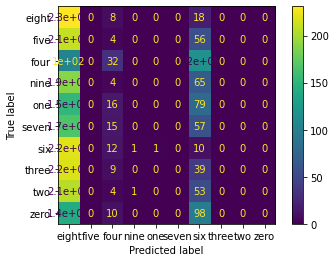

In [ ]:
# Confusion Matrix
plot_confusion_matrix(gnb_scaled, x_test, y_test)

In [ ]:
# Classification Report
gnb_report_scaled = classification_report(y_test,gnb_y_pred_scaled)
print(gnb_report_scaled)

              precision    recall  f1-score   support

       eight       0.63      0.62      0.63       257
        five       0.53      0.62      0.57       271
        four       0.66      0.57      0.61       253
        nine       0.60      0.48      0.54       259
         one       0.44      0.47      0.45       248
       seven       0.54      0.49      0.52       239
         six       0.48      0.66      0.56       244
       three       0.60      0.45      0.51       267
         two       0.41      0.50      0.45       264
        zero       0.57      0.50      0.53       250

    accuracy                           0.54      2552
   macro avg       0.55      0.54      0.54      2552
weighted avg       0.55      0.54      0.54      2552



# RandomForestClassifier

In [ ]:
# Entrenamos nuestro RFC con los datos estandarizados
rf = RandomForestClassifier(
    random_state=4589
)
rf.fit(x_train_scaled, y_train)
print("Accuracy training : {:.3f}".format(rf.score(x_train_scaled, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(x_val_scaled, y_val)))

Accuracy training : 1.000
Accuracy test: 0.686


## Parameter Tunning

In [12]:
# Tenemos que armar un folding específico para poder optimizar 
# correctamente los parametros utilizando nuestros sets de validación

x_train_fold = x_train.copy()
x_train_fold['fold'] = -1

x_val_fold = x_val.copy()
x_val_fold['fold'] = 0

x_combined_fold = x_train_fold.append(
    x_val_fold, 
    ignore_index=True
)

split_index = x_combined_fold['fold']

ps = PredefinedSplit(split_index)

In [13]:
# Armamos nuestros splits de optimización x_dev_rfc y y_dev_rfc
x_dev_rfc = x_train.append(x_val, ignore_index=True)
y_dev_rfc = y_train.append(y_val, ignore_index=True)

In [ ]:
# Como columnas para consumir tenemos un total de 79
parameters = {
    'n_estimators':range(50, 200, 10), 
    'max_depth':range(1,32, 1),
    'criterion': ['gini','entropy']
}

clf = RandomizedSearchCV(
    RandomForestClassifier(
      random_state=4589
    ), 
    n_iter=15,
    param_distributions= parameters,  
    scoring='accuracy',
    cv=ps,
    refit = False,
    random_state=4589
)

clf.fit(x_dev_rfc, y_dev_rfc)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                        

In [ ]:
print (clf.best_score_, clf.best_params_)


0.6908580593424218 {'n_estimators': 150, 'max_depth': 25, 'criterion': 'entropy'}


## Best Estimator

In [14]:
best_rfc = RandomForestClassifier(
  random_state=4589,
  bootstrap = True,
  max_depth = 25,
  n_estimators = 150,
  criterion = 'entropy'
)

best_rfc.fit(x_train,y_train)
print("Accuracy training : {:.3f}".format(best_rfc.score(x_train, y_train)))
print("Accuracy validation: {:.3f}".format(best_rfc.score(x_val, y_val)))

Accuracy training : 1.000
Accuracy validation: 0.688


In [15]:
rfc_y_pred_test = best_rfc.predict(x_test)

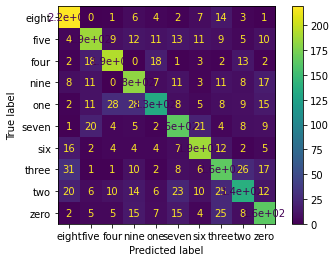

In [ ]:
# Matriz de confusión
plot_confusion_matrix(best_rfc, x_test, y_test)

In [ ]:
print(classification_report(y_test,rfc_y_pred_test))

              precision    recall  f1-score   support

       eight       0.72      0.85      0.78       257
        five       0.72      0.69      0.70       271
        four       0.76      0.77      0.76       253
        nine       0.66      0.71      0.68       259
         one       0.69      0.54      0.60       248
       seven       0.65      0.69      0.67       239
         six       0.73      0.77      0.75       244
       three       0.60      0.62      0.61       267
         two       0.63      0.52      0.57       264
        zero       0.65      0.66      0.65       250

    accuracy                           0.68      2552
   macro avg       0.68      0.68      0.68      2552
weighted avg       0.68      0.68      0.68      2552



# Gradient Boosting Machines

In [ ]:
gb = GradientBoostingClassifier(
    random_state=4589
)
gb.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_val, y_val)))

Accuracy on training set: 0.836
Accuracy on test set: 0.707


In [ ]:
parameters = {
    'n_estimators':range(50, 200, 10),  
    'max_depth':range(1,32, 1),
    'learning_rate': np.linspace(0 ,0.1, 10),
    'max_features': ['sqrt','log2']
}

clf = RandomizedSearchCV(
    GradientBoostingClassifier(
        random_state=4589
    ), 
    param_distributions= parameters,  
    scoring='accuracy',
    cv=ps,
    n_iter= 5,
    n_jobs=10,
    refit = False,
    random_state=4589
)

clf.fit(x_dev_rfc, y_dev_rfc)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        

In [ ]:
print (clf.best_score_, clf.best_params_)

0.7125100240577386 {'n_estimators': 180, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}


## Best Estimator

In [16]:
best_gbm = GradientBoostingClassifier(
    random_state = 4589,
    max_depth = 3,
    n_estimators = 180,
    learning_rate = 0.1,
    max_features = 'log2'
)

best_gbm.fit(x_train,y_train)
print("Accuracy training : {:.3f}".format(best_gbm.score(x_train, y_train)))
print("Accuracy validation: {:.3f}".format(best_gbm.score(x_val, y_val)))

Accuracy training : 0.863
Accuracy validation: 0.717


In [17]:
gbm_y_pred_test = best_gbm.predict(x_test)

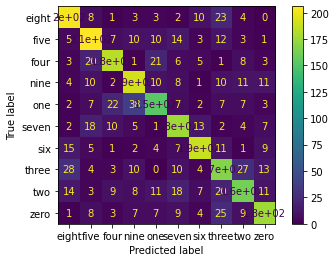

In [ ]:
# Matriz de confusión
plot_confusion_matrix(best_gbm, x_test, y_test)

In [ ]:
print(classification_report(y_test,gbm_y_pred_test))

              precision    recall  f1-score   support

       eight       0.73      0.79      0.76       257
        five       0.71      0.76      0.74       271
        four       0.76      0.73      0.75       253
        nine       0.70      0.74      0.72       259
         one       0.70      0.62      0.65       248
       seven       0.69      0.74      0.71       239
         six       0.79      0.77      0.78       244
       three       0.60      0.63      0.62       267
         two       0.69      0.62      0.65       264
        zero       0.75      0.71      0.73       250

    accuracy                           0.71      2552
   macro avg       0.71      0.71      0.71      2552
weighted avg       0.71      0.71      0.71      2552



# Análisis de Ruido

In [ ]:
def plot_confusion(model,x_test,y_test,ax,label=''):
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    c = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(c, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Real'
    df_cm.columns.name = f'Predicción'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 9}, cbar=False, fmt='g',ax=ax)# font size
    ax.set_title(label+ f' (acc={acc*100:.2f}%)')
    return y_pred,acc

def evaluate_all(csv_features_file):
    print(f'Evaluando el dataset> {csv_features_file}')

    df = pd.read_csv(
        'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/'+csv_features_file,
        index_col=0
    )

    y_test = df['digit']
    x_test = df.drop(['digit','filename'],axis=1)
    
    matplotlib.rcParams['figure.figsize'] = [12, 5]
    sns.set(font_scale=.9)#for label size

    fig, axs = plt.subplots(2, 2,)
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.subplots_adjust(wspace=.2, hspace=.45)
    
    
    x_test_scaled = pd.DataFrame(scaler.transform(x_test))
    
    acc = {}
    acc['dataset'] = csv_features_file[:-4]
    y_pred,acc['gnb'] = plot_confusion(gnb,x_test,y_test,axs[0,0],'Naive Bayes Gaussiano')
    y_pred,acc['gnb_scaled'] = plot_confusion(gnb_scaled,x_test_scaled,y_test,axs[0,1],'Naive Bayes Gaussiano Escalado')
    y_pred,acc['best_rfc'] = plot_confusion(best_rfc,x_test,y_test,axs[1,0],'Clasificador Random Forest')
    y_pred,acc['best_gbm'] = plot_confusion(best_gbm,x_test,y_test,axs[1,1],'Gradient Boosting Machine')
    fig.suptitle(f'Matriz de Confusión de cada Modelo [{csv_features_file}]')
    plt.savefig('imagenes/'+csv_features_file[:-4]+'.png')
    print(f'accuracy> {acc}')
    return accdef plot_confusion(model,x_test,y_test,ax,label=''):
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    c = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(c, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Real'
    df_cm.columns.name = f'Predicción'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 9}, cbar=False, fmt='g',ax=ax)# font size
    ax.set_title(label+ f' (acc={acc*100:.2f}%)')
    return y_pred,acc

def evaluate_all(csv_features_file):
    print(f'Evaluando el dataset> {csv_features_file}')

    df = pd.read_csv(
        'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/'+csv_features_file,
        index_col=0
    )

    y_test = df['digit']
    x_test = df.drop(['digit','filename'],axis=1)
    
    matplotlib.rcParams['figure.figsize'] = [12, 5]
    sns.set(font_scale=.9)#for label size

    fig, axs = plt.subplots(2, 2,)
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    fig.subplots_adjust(wspace=.2, hspace=.45)
    
    
    x_test_scaled = pd.DataFrame(scaler.transform(x_test))
    
    acc = {}
    acc['dataset'] = csv_features_file[:-4]
    y_pred,acc['gnb'] = plot_confusion(gnb,x_test,y_test,axs[0,0],'Naive Bayes Gaussiano')
    y_pred,acc['gnb_scaled'] = plot_confusion(gnb_scaled,x_test_scaled,y_test,axs[0,1],'Naive Bayes Gaussiano Escalado')
    y_pred,acc['best_rfc'] = plot_confusion(best_rfc,x_test,y_test,axs[1,0],'Clasificador Random Forest')
    y_pred,acc['best_gbm'] = plot_confusion(best_gbm,x_test,y_test,axs[1,1],'Gradient Boosting Machine')
    fig.suptitle(f'Matriz de Confusión de cada Modelo [{csv_features_file}]')
    plt.savefig('imagenes/'+csv_features_file[:-4]+'.png')
    print(f'accuracy> {acc}')
    return acc

In [ ]:
acc = pd.DataFrame()
k = evaluate_all('audio_digits_RUIDO_BLANCO_3000.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_1000.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_300.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_100.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_30.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_10.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_RUIDO_BLANCO_3.csv')
acc = acc.append(k, ignore_index=True)
acc

In [ ]:
k = evaluate_all('audio_digits_CAFE-CAFE-1_lvl_10.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_CAFE-FOODCOURTB-1_lvl_10.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_HOME-KITCHEN-1_lvl_10.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('audio_digits_STREET-CITY-1_lvl_10.csv')
acc = acc.append(k, ignore_index=True)
k = evaluate_all('self_recorded_digits.csv')
acc = acc.append(k, ignore_index=True)
acc

In [ ]:
acc.set_index('dataset')

## Ruido Blanco Aditivo

Vamos a utilizar las particiones previamente armadas en la variable **tipo_split** para tener los splits consistentes.

### AWN20

In [ ]:
df_awn20 = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_AWN20.csv',
    index_col=0
)

awn20_target = df_awn20['digit']
awn20_features = df_awn20.drop(['digit','filename'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
awn20_scaled_features = pd.DataFrame(scaler.fit_transform(awn20_features))

print(f'Held-out: {len(awn20_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.71      0.22      0.34       257
        five       0.62      0.62      0.62       271
        four       0.49      0.62      0.55       253
        nine       0.53      0.07      0.12       259
         one       0.38      0.52      0.44       248
       seven       0.51      0.23      0.32       239
         six       0.96      0.23      0.37       244
       three       0.42      0.19      0.26       267
         two       0.20      0.88      0.32       264
        zero       0.79      0.11      0.19       250

    accuracy                           0.37      2552
   macro avg       0.56      0.37      0.35      2552
weighted avg       0.56      0.37      0.35      2552



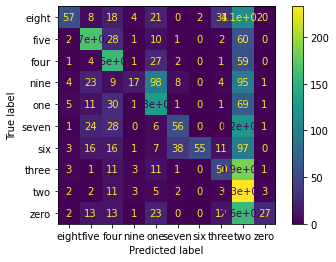

In [ ]:
# No scaled
awn20_pred = gnb.predict(awn20_features)

# Confusion Matrix
plot_confusion_matrix(gnb, awn20_features, awn20_target)

# Classification Report
awn20_report = classification_report(awn20_target,awn20_pred)
print(awn20_report)

              precision    recall  f1-score   support

       eight       0.67      0.66      0.67       257
        five       0.66      0.70      0.68       271
        four       0.63      0.68      0.65       253
        nine       0.62      0.47      0.54       259
         one       0.45      0.54      0.49       248
       seven       0.64      0.71      0.67       239
         six       0.69      0.65      0.67       244
       three       0.54      0.48      0.50       267
         two       0.47      0.50      0.48       264
        zero       0.64      0.58      0.61       250

    accuracy                           0.60      2552
   macro avg       0.60      0.60      0.60      2552
weighted avg       0.60      0.60      0.59      2552



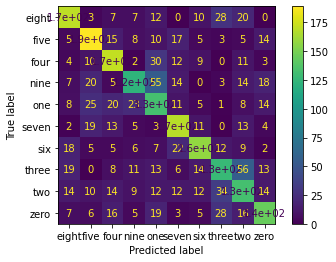

In [ ]:
# Scaled
awn20_pred_scaled = gnb_scaled.predict(awn20_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, awn20_scaled_features, awn20_target)

# Classification Report
awn20_scaled_report = classification_report(awn20_target, awn20_pred_scaled)
print(awn20_scaled_report)

#### RandomForest

              precision    recall  f1-score   support

       eight       0.68      0.74      0.71       257
        five       0.91      0.45      0.60       271
        four       0.63      0.74      0.68       253
        nine       0.69      0.44      0.54       259
         one       0.55      0.53      0.54       248
       seven       0.64      0.65      0.65       239
         six       0.55      0.75      0.64       244
       three       0.51      0.36      0.42       267
         two       0.37      0.65      0.47       264
        zero       0.66      0.55      0.60       250

    accuracy                           0.58      2552
   macro avg       0.62      0.59      0.58      2552
weighted avg       0.62      0.58      0.58      2552



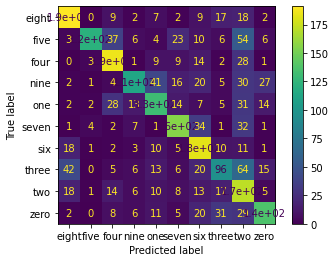

In [ ]:
awn20_pred = best_rfc.predict(awn20_features)

# Matriz de confusión
plot_confusion_matrix(best_rfc, awn20_features, awn20_target)

print(classification_report(awn20_target, awn20_pred))

#### GradientBoosting

              precision    recall  f1-score   support

       eight       0.77      0.70      0.73       257
        five       0.92      0.57      0.70       271
        four       0.64      0.79      0.71       253
        nine       0.80      0.42      0.55       259
         one       0.75      0.52      0.61       248
       seven       0.71      0.72      0.72       239
         six       0.59      0.89      0.71       244
       three       0.62      0.38      0.47       267
         two       0.42      0.78      0.55       264
        zero       0.64      0.67      0.65       250

    accuracy                           0.64      2552
   macro avg       0.69      0.65      0.64      2552
weighted avg       0.69      0.64      0.64      2552



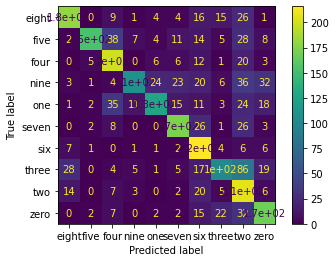

In [ ]:
gbm_awn20_pred = best_gbm.predict(awn20_features)

# Matriz de confusión
plot_confusion_matrix(best_gbm, awn20_features, awn20_target)

print(classification_report(awn20_target, gbm_awn20_pred))

### AWN40

In [ ]:
df_awn40 = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_AWN40.csv',
    index_col=0
)

awn40_target = df_awn40['digit']
awn40_features = df_awn40.drop(['digit','filename'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
awn40_scaled_features = pd.DataFrame(scaler.fit_transform(awn40_features))

print(f'Held-out: {len(awn40_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.76      0.38      0.50       257
        five       0.63      0.66      0.65       271
        four       0.55      0.64      0.59       253
        nine       0.67      0.15      0.24       259
         one       0.38      0.61      0.47       248
       seven       0.62      0.42      0.50       239
         six       0.86      0.42      0.57       244
       three       0.49      0.33      0.39       267
         two       0.27      0.81      0.40       264
        zero       0.69      0.33      0.45       250

    accuracy                           0.48      2552
   macro avg       0.59      0.48      0.48      2552
weighted avg       0.59      0.48      0.47      2552



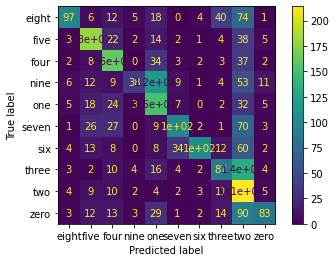

In [ ]:
## No Scale
awn40_pred = gnb.predict(awn40_features)

# Confusion Matrix
plot_confusion_matrix(gnb, awn40_features, awn40_target)

# Classification Report
awn40_report = classification_report(awn40_target,awn40_pred)
print(awn40_report)

              precision    recall  f1-score   support

       eight       0.68      0.66      0.67       257
        five       0.70      0.71      0.71       271
        four       0.66      0.65      0.65       253
        nine       0.67      0.49      0.56       259
         one       0.43      0.56      0.49       248
       seven       0.62      0.69      0.65       239
         six       0.69      0.70      0.69       244
       three       0.59      0.51      0.55       267
         two       0.45      0.49      0.47       264
        zero       0.65      0.61      0.63       250

    accuracy                           0.61      2552
   macro avg       0.61      0.61      0.61      2552
weighted avg       0.61      0.61      0.61      2552



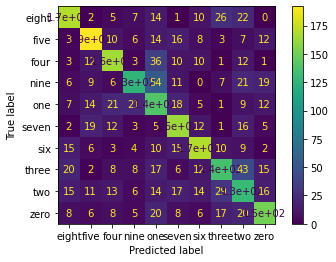

In [ ]:

## Scaled
awn40_pred_scaled = gnb_scaled.predict(awn40_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, awn40_scaled_features, awn40_target)

# Classification Report
awn40_scaled_report = classification_report(awn40_target, awn40_pred_scaled)
print(awn40_scaled_report)

#### RandomForest

              precision    recall  f1-score   support

       eight       0.72      0.77      0.75       257
        five       0.88      0.56      0.69       271
        four       0.67      0.77      0.72       253
        nine       0.70      0.46      0.55       259
         one       0.60      0.54      0.57       248
       seven       0.60      0.71      0.65       239
         six       0.66      0.78      0.72       244
       three       0.54      0.48      0.51       267
         two       0.45      0.65      0.53       264
        zero       0.67      0.62      0.65       250

    accuracy                           0.63      2552
   macro avg       0.65      0.64      0.63      2552
weighted avg       0.65      0.63      0.63      2552



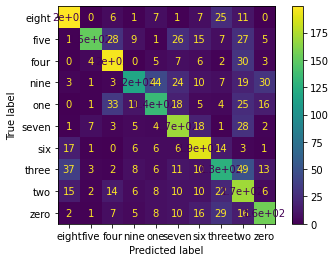

In [ ]:
awn40_pred = best_rfc.predict(awn40_features)

# Matriz de confusión
plot_confusion_matrix(best_rfc, awn40_features, awn40_target)

print(classification_report(awn40_target, awn40_pred))

#### GradientBoosting

              precision    recall  f1-score   support

       eight       0.78      0.73      0.76       257
        five       0.85      0.65      0.74       271
        four       0.68      0.83      0.74       253
        nine       0.80      0.48      0.60       259
         one       0.75      0.55      0.64       248
       seven       0.66      0.77      0.71       239
         six       0.74      0.85      0.79       244
       three       0.64      0.50      0.56       267
         two       0.47      0.75      0.58       264
        zero       0.68      0.73      0.70       250

    accuracy                           0.68      2552
   macro avg       0.71      0.68      0.68      2552
weighted avg       0.71      0.68      0.68      2552



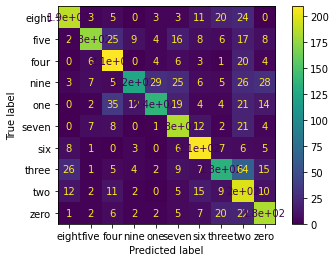

In [ ]:
gbm_awn40_pred = best_gbm.predict(awn40_features)

# Matriz de confusión
plot_confusion_matrix(best_gbm, awn40_features, awn40_target)

print(classification_report(awn40_target, gbm_awn40_pred))

### AWN100

In [ ]:
df_awn100 = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_AWN100.csv',
    index_col=0
)

awn100_target = df_awn100['digit']
awn100_features = df_awn100.drop(['digit','filename'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
awn100_scaled_features = pd.DataFrame(scaler.fit_transform(awn100_features))

print(f'Held-out: {len(awn100_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.74      0.52      0.61       257
        five       0.62      0.69      0.66       271
        four       0.62      0.65      0.63       253
        nine       0.73      0.32      0.45       259
         one       0.43      0.63      0.51       248
       seven       0.61      0.54      0.57       239
         six       0.69      0.57      0.62       244
       three       0.52      0.46      0.49       267
         two       0.36      0.66      0.46       264
        zero       0.63      0.50      0.56       250

    accuracy                           0.55      2552
   macro avg       0.60      0.55      0.56      2552
weighted avg       0.60      0.55      0.56      2552



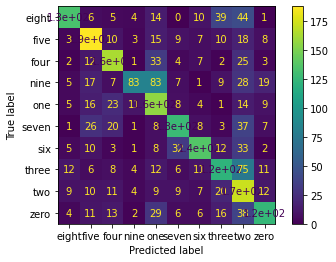

In [ ]:
## No Scale
awn100_pred = gnb.predict(awn100_features)

# Confusion Matrix
plot_confusion_matrix(gnb, awn100_features, awn100_target)

# Classification Report
awn100_report = classification_report(awn100_target,awn100_pred)
print(awn100_report)

              precision    recall  f1-score   support

       eight       0.68      0.65      0.67       257
        five       0.68      0.68      0.68       271
        four       0.67      0.66      0.66       253
        nine       0.65      0.47      0.55       259
         one       0.42      0.56      0.48       248
       seven       0.61      0.61      0.61       239
         six       0.62      0.69      0.66       244
       three       0.62      0.49      0.55       267
         two       0.45      0.52      0.48       264
        zero       0.62      0.59      0.60       250

    accuracy                           0.59      2552
   macro avg       0.60      0.59      0.59      2552
weighted avg       0.60      0.59      0.59      2552



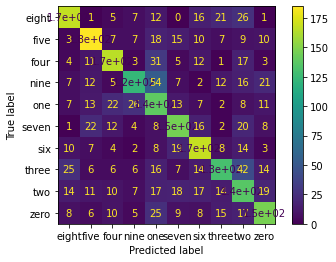

In [ ]:
## Scaled
awn100_pred_scaled = gnb_scaled.predict(awn100_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, awn100_scaled_features, awn100_target)

# Classification Report
awn100_scaled_report = classification_report(awn100_target, awn100_pred_scaled)
print(awn100_scaled_report)

#### RandomForest

              precision    recall  f1-score   support

       eight       0.75      0.81      0.78       257
        five       0.80      0.63      0.70       271
        four       0.68      0.79      0.73       253
        nine       0.71      0.59      0.65       259
         one       0.66      0.52      0.58       248
       seven       0.63      0.71      0.67       239
         six       0.72      0.77      0.75       244
       three       0.57      0.60      0.58       267
         two       0.53      0.57      0.55       264
        zero       0.66      0.68      0.67       250

    accuracy                           0.67      2552
   macro avg       0.67      0.67      0.67      2552
weighted avg       0.67      0.67      0.67      2552



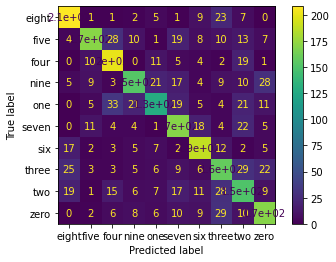

In [ ]:
awn100_pred = best_rfc.predict(awn100_features)

# Matriz de confusión
plot_confusion_matrix(best_rfc, awn100_features, awn100_target)

print(classification_report(awn100_target, awn100_pred))

#### Gradient Boosting

              precision    recall  f1-score   support

       eight       0.78      0.76      0.77       257
        five       0.80      0.71      0.75       271
        four       0.72      0.79      0.76       253
        nine       0.80      0.57      0.67       259
         one       0.74      0.62      0.68       248
       seven       0.66      0.79      0.72       239
         six       0.81      0.82      0.81       244
       three       0.60      0.61      0.60       267
         two       0.58      0.69      0.63       264
        zero       0.69      0.74      0.71       250

    accuracy                           0.71      2552
   macro avg       0.72      0.71      0.71      2552
weighted avg       0.72      0.71      0.71      2552



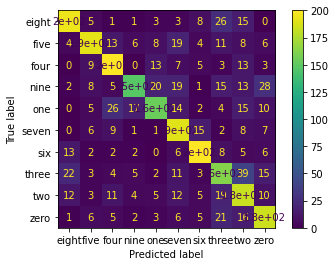

In [ ]:
gbm_awn100_pred = best_gbm.predict(awn100_features)

# Matriz de confusión
plot_confusion_matrix(best_gbm, awn100_features, awn100_target)

print(classification_report(awn100_target, gbm_awn100_pred))

## Ruido Ambiente

###  **Cafe**

In [ ]:
df_cafe = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_CAFE-CAFE-1_lvl_10.csv',
    index_col=0
)

df_cafe['split'] = tipo_split
df_cafe_test = df_cafe[df_cafe['split'] == 'test']

cafe_target = df_cafe_test['digit']
cafe_features = df_cafe_test.drop(['digit','filename', 'split'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
cafe_scaled_features = pd.DataFrame(scaler.fit_transform(cafe_features))

print(f'Held-out: {len(cafe_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.18      0.03      0.05       257
        five       0.31      0.34      0.32       271
        four       0.38      0.19      0.26       253
        nine       0.43      0.02      0.04       259
         one       0.20      0.40      0.27       248
       seven       0.58      0.03      0.06       239
         six       1.00      0.00      0.01       244
       three       0.25      0.00      0.01       267
         two       0.14      0.83      0.24       264
        zero       0.55      0.02      0.05       250

    accuracy                           0.19      2552
   macro avg       0.40      0.19      0.13      2552
weighted avg       0.40      0.19      0.13      2552



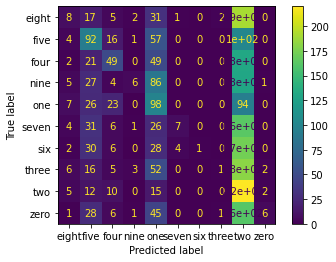

In [ ]:
# No Scaled
gnb_cafe_pred = gnb.predict(cafe_features)

# Confusion Matrix
plot_confusion_matrix(gnb, cafe_features, cafe_target)

# Classification Report
gnb_cafe_report = classification_report(cafe_target,gnb_cafe_pred)
print(gnb_cafe_report)

              precision    recall  f1-score   support

       eight       0.43      0.21      0.28       257
        five       0.30      0.26      0.28       271
        four       0.42      0.24      0.30       253
        nine       0.36      0.25      0.30       259
         one       0.22      0.37      0.27       248
       seven       0.34      0.33      0.33       239
         six       0.32      0.41      0.36       244
       three       0.32      0.31      0.31       267
         two       0.19      0.30      0.23       264
        zero       0.32      0.29      0.30       250

    accuracy                           0.30      2552
   macro avg       0.32      0.30      0.30      2552
weighted avg       0.32      0.30      0.30      2552



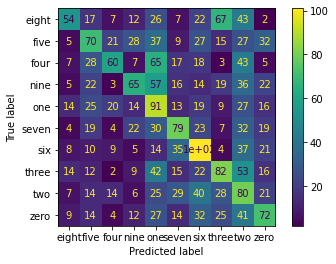

In [ ]:
# Scaled
gnb_cafe_pred_scaled = gnb_scaled.predict(cafe_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, cafe_scaled_features, cafe_target)

# Classification Report
gnb_cafe_report_scaled = classification_report(cafe_target,gnb_cafe_pred_scaled)
print(gnb_cafe_report_scaled)

#### Random Forest

              precision    recall  f1-score   support

       eight       0.34      0.38      0.36       257
        five       0.60      0.16      0.25       271
        four       0.30      0.44      0.36       253
        nine       0.34      0.45      0.39       259
         one       0.25      0.46      0.33       248
       seven       0.41      0.23      0.29       239
         six       0.78      0.13      0.22       244
       three       0.38      0.27      0.31       267
         two       0.26      0.53      0.35       264
        zero       0.49      0.24      0.32       250

    accuracy                           0.33      2552
   macro avg       0.41      0.33      0.32      2552
weighted avg       0.41      0.33      0.32      2552



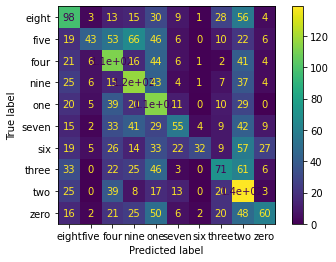

In [ ]:
rfc_cafe_pred = best_rfc.predict(cafe_features)

# Matriz de confusión
plot_confusion_matrix(best_rfc, cafe_features, cafe_target)

print(classification_report(cafe_target, rfc_cafe_pred))

#### Gradient Boosting

              precision    recall  f1-score   support

       eight       0.35      0.37      0.36       257
        five       0.66      0.20      0.30       271
        four       0.34      0.47      0.40       253
        nine       0.38      0.46      0.42       259
         one       0.33      0.35      0.34       248
       seven       0.44      0.41      0.42       239
         six       0.43      0.33      0.38       244
       three       0.44      0.24      0.31       267
         two       0.26      0.53      0.35       264
        zero       0.44      0.29      0.35       250

    accuracy                           0.37      2552
   macro avg       0.41      0.37      0.36      2552
weighted avg       0.41      0.37      0.36      2552



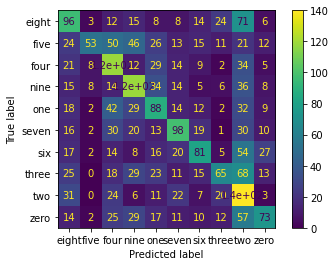

In [ ]:
gbm_cafe_pred = best_gbm.predict(cafe_features)

# Matriz de confusión
plot_confusion_matrix(best_gbm, cafe_features, cafe_target)

print(classification_report(cafe_target, gbm_cafe_pred))

### **Cafe Foodcourt**

In [19]:
df_foodcourt = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_CAFE-FOODCOURTB-1_lvl_10.csv',
    index_col=0
)

df_foodcourt['split'] = tipo_split
df_foodcourt_test = df_foodcourt[df_foodcourt['split'] == 'test']

foodcourt_target = df_foodcourt_test['digit']
foodcourt_features = df_foodcourt_test.drop(['digit','filename', 'split'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
foodcourt_scaled_features = pd.DataFrame(scaler.fit_transform(foodcourt_features))

print(f'Held-out: {len(foodcourt_features)}')

Held-out: 2552


In [ ]:
foodcourt_scaled_features.shape

(2552, 78)

#### Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       eight       0.14      0.23      0.17       257
        five       0.41      0.17      0.24       271
        four       0.23      0.13      0.17       253
        nine       0.17      0.00      0.01       259
         one       0.22      0.13      0.17       248
       seven       0.00      0.00      0.00       239
         six       0.00      0.00      0.00       244
       three       0.00      0.00      0.00       267
         two       0.12      0.76      0.20       264
        zero       0.00      0.00      0.00       250

    accuracy                           0.15      2552
   macro avg       0.13      0.14      0.10      2552
weighted avg       0.13      0.15      0.10      2552



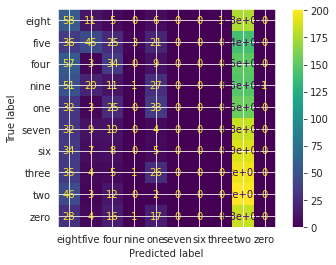

In [20]:
## No Scale
foodcourt_pred = gnb.predict(foodcourt_features)

# Confusion Matrix
plot_confusion_matrix(gnb, foodcourt_features, foodcourt_target)

# Classification Report
foodcourt_report = classification_report(foodcourt_target,foodcourt_pred)
print(foodcourt_report)

              precision    recall  f1-score   support

       eight       0.36      0.19      0.25       257
        five       0.26      0.20      0.22       271
        four       0.43      0.22      0.29       253
        nine       0.35      0.23      0.28       259
         one       0.19      0.37      0.25       248
       seven       0.32      0.25      0.28       239
         six       0.32      0.41      0.36       244
       three       0.27      0.20      0.23       267
         two       0.15      0.30      0.20       264
        zero       0.29      0.22      0.25       250

    accuracy                           0.26      2552
   macro avg       0.29      0.26      0.26      2552
weighted avg       0.29      0.26      0.26      2552



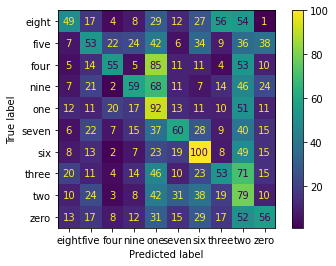

In [ ]:
## Scaled Naive Bayes
foodcourt_pred_scaled = gnb_scaled.predict(foodcourt_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, foodcourt_scaled_features, foodcourt_target, values_format='d')

# Classification Report
foodcourt_scaled_report = classification_report(foodcourt_target, foodcourt_pred_scaled)
print(foodcourt_scaled_report)

#### RandomForest

              precision    recall  f1-score   support

       eight       0.16      0.52      0.24       257
        five       0.50      0.02      0.04       271
        four       0.19      0.28      0.23       253
        nine       0.22      0.32      0.26       259
         one       0.16      0.46      0.24       248
       seven       0.57      0.02      0.03       239
         six       0.86      0.02      0.05       244
       three       0.35      0.07      0.11       267
         two       0.35      0.16      0.22       264
        zero       0.57      0.05      0.10       250

    accuracy                           0.19      2552
   macro avg       0.39      0.19      0.15      2552
weighted avg       0.39      0.19      0.15      2552



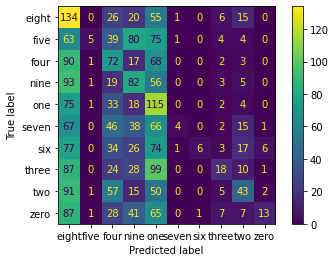

In [ ]:
## Random Forest
foodcourt_pred_rfc = best_rfc.predict(foodcourt_features)

# Confusion Matrix
plot_confusion_matrix(best_rfc, foodcourt_features, foodcourt_target, values_format='d')

# Classification Report
foodcourt_rfc_report = classification_report(foodcourt_target, foodcourt_pred_rfc)
print(foodcourt_rfc_report)

#### GradientBoosting

              precision    recall  f1-score   support

       eight       0.19      0.50      0.27       257
        five       0.50      0.02      0.04       271
        four       0.19      0.27      0.22       253
        nine       0.29      0.34      0.31       259
         one       0.20      0.30      0.24       248
       seven       0.33      0.21      0.25       239
         six       0.46      0.05      0.09       244
       three       0.30      0.04      0.07       267
         two       0.20      0.36      0.26       264
        zero       0.26      0.13      0.17       250

    accuracy                           0.22      2552
   macro avg       0.29      0.22      0.19      2552
weighted avg       0.29      0.22      0.19      2552



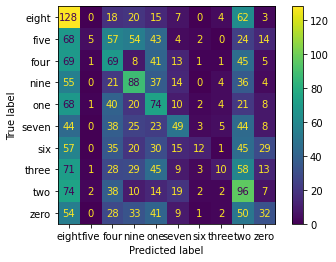

In [ ]:
## gradient boosting
foodcourt_pred_gbm = best_gbm.predict(foodcourt_features)

# Confusion Matrix
plot_confusion_matrix(best_gbm, foodcourt_features, foodcourt_target, values_format='d')

# Classification Report
foodcourt_gbm_report = classification_report(foodcourt_target, foodcourt_pred_gbm)
print(foodcourt_gbm_report)

### **Home Kitchen**

In [21]:
df_kitchen = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_HOME-KITCHEN-1_lvl_10.csv',
    index_col=0
)

df_kitchen['split'] = tipo_split
df_kitchen_test = df_kitchen[df_kitchen['split'] == 'test']

kitchen_target = df_kitchen_test['digit']
kitchen_features = df_kitchen_test.drop(['digit','filename', 'split'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
kitchen_scaled_features = pd.DataFrame(scaler.fit_transform(kitchen_features))

print(f'Held-out: {len(kitchen_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.65      0.20      0.31       257
        five       0.34      0.61      0.44       271
        four       0.55      0.38      0.45       253
        nine       0.58      0.14      0.22       259
         one       0.27      0.65      0.38       248
       seven       0.61      0.29      0.39       239
         six       0.73      0.21      0.33       244
       three       0.55      0.22      0.32       267
         two       0.25      0.70      0.37       264
        zero       0.63      0.25      0.36       250

    accuracy                           0.37      2552
   macro avg       0.51      0.37      0.36      2552
weighted avg       0.51      0.37      0.36      2552



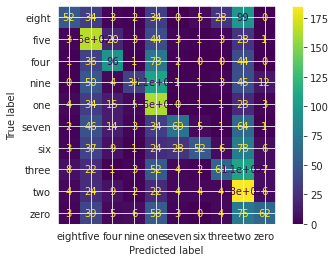

In [23]:
## No Scale
kitchen_pred = gnb.predict(kitchen_features)

# Confusion Matrix
plot_confusion_matrix(gnb, kitchen_features, kitchen_target)

# Classification Report
kitchen_report = classification_report(kitchen_target,kitchen_pred)
print(kitchen_report)

              precision    recall  f1-score   support

       eight       0.59      0.39      0.47       257
        five       0.45      0.49      0.47       271
        four       0.64      0.46      0.54       253
        nine       0.56      0.36      0.44       259
         one       0.40      0.54      0.46       248
       seven       0.56      0.52      0.54       239
         six       0.44      0.55      0.49       244
       three       0.47      0.43      0.45       267
         two       0.32      0.50      0.39       264
        zero       0.55      0.50      0.52       250

    accuracy                           0.47      2552
   macro avg       0.50      0.47      0.48      2552
weighted avg       0.50      0.47      0.48      2552



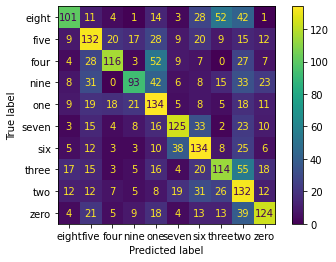

In [ ]:

## Scaled Naive Bayes
kitchen_pred_scaled = gnb_scaled.predict(kitchen_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, kitchen_scaled_features, kitchen_target, values_format='d')

# Classification Report
kitchen_scaled_report = classification_report(kitchen_target, kitchen_pred_scaled)
print(kitchen_scaled_report)

#### Random Forest

              precision    recall  f1-score   support

       eight       0.64      0.75      0.69       257
        five       0.67      0.56      0.61       271
        four       0.64      0.67      0.66       253
        nine       0.56      0.64      0.60       259
         one       0.52      0.60      0.56       248
       seven       0.63      0.62      0.62       239
         six       0.81      0.57      0.67       244
       three       0.65      0.54      0.59       267
         two       0.44      0.64      0.52       264
        zero       0.78      0.51      0.62       250

    accuracy                           0.61      2552
   macro avg       0.63      0.61      0.61      2552
weighted avg       0.63      0.61      0.61      2552



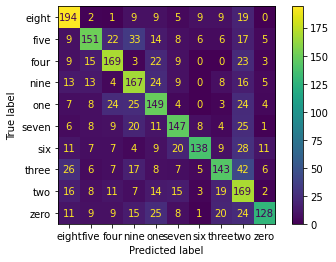

In [ ]:
## Random Forest
kitchen_pred_rfc = best_rfc.predict(kitchen_features)

# Confusion Matrix
plot_confusion_matrix(best_rfc, kitchen_features, kitchen_target, values_format='d')

# Classification Report
kitchen_rfc_report = classification_report(kitchen_target, kitchen_pred_rfc)
print(kitchen_rfc_report)

#### Gradient Boosting

              precision    recall  f1-score   support

       eight       0.66      0.67      0.67       257
        five       0.65      0.61      0.62       271
        four       0.60      0.66      0.63       253
        nine       0.61      0.65      0.63       259
         one       0.60      0.57      0.59       248
       seven       0.67      0.63      0.65       239
         six       0.61      0.70      0.65       244
       three       0.67      0.51      0.58       267
         two       0.44      0.63      0.52       264
        zero       0.76      0.50      0.61       250

    accuracy                           0.61      2552
   macro avg       0.63      0.61      0.61      2552
weighted avg       0.63      0.61      0.61      2552



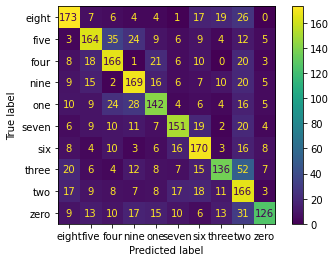

In [ ]:
## gradient boosting
kitchen_pred_gbm = best_gbm.predict(kitchen_features)

# Confusion Matrix
plot_confusion_matrix(best_gbm, kitchen_features, kitchen_target, values_format='d')

# Classification Report
kitchen_gbm_report = classification_report(kitchen_target, kitchen_pred_gbm)
print(kitchen_gbm_report)

### **Street**

In [24]:
df_street = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/audio_digits_STREET-CITY-1_lvl_10.csv',
    index_col=0
)

df_street['split'] = tipo_split
df_street_test = df_street[df_street['split'] == 'test']

street_target = df_street_test['digit']
street_features = df_street_test.drop(['digit','filename', 'split'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
street_scaled_features = pd.DataFrame(scaler.fit_transform(street_features))

print(f'Held-out: {len(street_features)}')

Held-out: 2552


#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.11      0.13      0.12       257
        five       0.41      0.27      0.33       271
        four       0.34      0.17      0.22       253
        nine       0.40      0.03      0.06       259
         one       0.17      0.56      0.27       248
       seven       0.58      0.03      0.06       239
         six       0.75      0.01      0.02       244
       three       0.42      0.03      0.06       267
         two       0.18      0.74      0.29       264
        zero       0.52      0.05      0.09       250

    accuracy                           0.20      2552
   macro avg       0.39      0.20      0.15      2552
weighted avg       0.39      0.20      0.15      2552



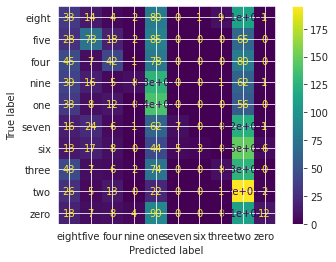

In [25]:
## No Scale
street_pred = gnb.predict(street_features)

# Confusion Matrix
plot_confusion_matrix(gnb, street_features, street_target)

# Classification Report
street_report = classification_report(street_target,street_pred)
print(street_report)

              precision    recall  f1-score   support

       eight       0.38      0.20      0.26       257
        five       0.30      0.34      0.32       271
        four       0.57      0.31      0.40       253
        nine       0.48      0.24      0.32       259
         one       0.25      0.47      0.33       248
       seven       0.50      0.31      0.39       239
         six       0.34      0.49      0.40       244
       three       0.37      0.27      0.31       267
         two       0.20      0.40      0.27       264
        zero       0.44      0.33      0.38       250

    accuracy                           0.33      2552
   macro avg       0.38      0.33      0.34      2552
weighted avg       0.38      0.33      0.34      2552



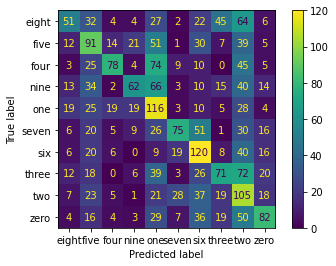

In [ ]:
## Scaled Naive Bayes
street_pred_scaled = gnb_scaled.predict(street_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, street_scaled_features, street_target, values_format='d')

# Classification Report
street_scaled_report = classification_report(street_target, street_pred_scaled)
print(street_scaled_report)

#### Random Forest

              precision    recall  f1-score   support

       eight       0.35      0.47      0.40       257
        five       0.62      0.14      0.23       271
        four       0.36      0.49      0.42       253
        nine       0.27      0.60      0.37       259
         one       0.27      0.57      0.37       248
       seven       0.56      0.19      0.29       239
         six       0.54      0.14      0.22       244
       three       0.47      0.31      0.37       267
         two       0.42      0.38      0.40       264
        zero       0.62      0.33      0.43       250

    accuracy                           0.36      2552
   macro avg       0.45      0.36      0.35      2552
weighted avg       0.45      0.36      0.35      2552



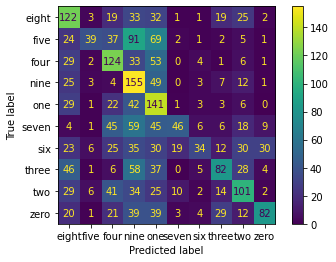

In [ ]:
## Random Forest
street_pred_rfc = best_rfc.predict(street_features)

# Confusion Matrix
plot_confusion_matrix(best_rfc, street_features, street_target, values_format='d')

# Classification Report
street_rfc_report = classification_report(street_target, street_pred_rfc)
print(street_rfc_report)

#### Gradient Boosting

              precision    recall  f1-score   support

       eight       0.48      0.38      0.42       257
        five       0.64      0.21      0.32       271
        four       0.38      0.59      0.46       253
        nine       0.30      0.54      0.39       259
         one       0.33      0.50      0.39       248
       seven       0.64      0.29      0.40       239
         six       0.47      0.32      0.38       244
       three       0.43      0.41      0.42       267
         two       0.41      0.46      0.43       264
        zero       0.45      0.38      0.42       250

    accuracy                           0.41      2552
   macro avg       0.45      0.41      0.40      2552
weighted avg       0.45      0.41      0.40      2552



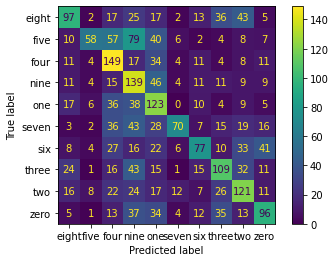

In [ ]:
## gradient boosting
street_pred_gbm = best_gbm.predict(street_features)

# Confusion Matrix
plot_confusion_matrix(best_gbm, street_features, street_target, values_format='d')

# Classification Report
street_gbm_report = classification_report(street_target, street_pred_gbm)
print(street_gbm_report)

# Self recorded

In [26]:
df_self_recorded = pd.read_csv(
    'https://raw.githubusercontent.com/francotestori/aauba_02/master/resources/self_recorded_digits.csv',
    index_col=0
)

df_self_recorded.head()

,ddenergy_mean,ddenergy_std,ddmfcc_0_mean,ddmfcc_0_std,ddmfcc_10_mean,ddmfcc_10_std,ddmfcc_11_mean,ddmfcc_11_std,ddmfcc_1_mean,ddmfcc_1_std,ddmfcc_2_mean,ddmfcc_2_std,ddmfcc_3_mean,ddmfcc_3_std,ddmfcc_4_mean,ddmfcc_4_std,ddmfcc_5_mean,ddmfcc_5_std,ddmfcc_6_mean,ddmfcc_6_std,ddmfcc_7_mean,ddmfcc_7_std,ddmfcc_8_mean,ddmfcc_8_std,ddmfcc_9_mean,ddmfcc_9_std,denergy_mean,denergy_std,digit,dmfcc_0_mean,dmfcc_0_std,dmfcc_10_mean,dmfcc_10_std,dmfcc_11_mean,dmfcc_11_std,dmfcc_1_mean,dmfcc_1_std,dmfcc_2_mean,dmfcc_2_std,dmfcc_3_mean,dmfcc_3_std,dmfcc_4_mean,dmfcc_4_std,dmfcc_5_mean,dmfcc_5_std,dmfcc_6_mean,dmfcc_6_std,dmfcc_7_mean,dmfcc_7_std,dmfcc_8_mean,dmfcc_8_std,dmfcc_9_mean,dmfcc_9_std,energy_mean,energy_std,filename,mfcc_0_mean,mfcc_0_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std
0,6.631199e-05,0.004150,-0.990160,27.788267,0.153122,6.530779,-0.121697,5.139882,0.413138,21.068680,-0.361077,13.277584,-0.158592,10.066796,0.404407,10.867157,-0.117777,8.181867,0.435786,7.054892,0.139111,7.420743,-0.088666,7.647155,-0.021643,5.751491,0.000366,0.006022,zero,1.108751,28.253345,0.003323,5.744915,-0.095066,4.450316,-1.816639,22.910681,1.660985,14.227742,-1.380682,12.494961,1.109308,11.486742,-0.205259,6.446996,0.153839,5.695142,0.128279,6.385761,-0.059712,6.393409,-0.302925,5.314495,0.026205,0.024709,./Particiones_grabadas/zero\anto-0-0.wav,-354.630035,71.799210,-5.623130,8.360927,-5.358375,9.373195,88.333801,60.419739,15.706279,34.843117,22.163809,28.238226,-4.551068,23.596987,9.918743,12.048921,4.123312,5.742887,1.853000,13.878942,-12.008492,12.029095,-0.861103,8.643719
1,5.642764e-06,0.003857,0.585283,27.026859,-0.138353,6.504038,-0.102408,5.289505,-1.082853,23.488014,0.562830,16.739023,0.189138,11.585762,-0.159397,10.178791,0.016886,9.339890,-0.078201,8.473952,-0.185614,8.473232,-0.143784,8.253882,-0.067081,5.325772,0.000101,0.004868,zero,2.343334,25.618706,-0.113745,5.647991,0.404380,4.238844,-2.802489,24.175247,1.560753,15.912974,-0.765137,12.863803,0.416949,10.355320,-0.253683,7.819773,0.469654,6.173600,-0.215925,7.122312,0.302502,6.245064,0.070923,4.031158,0.021431,0.018066,./Particiones_grabadas/zero\anto-0-1.wav,-380.337921,71.139481,-2.964714,8.592281,-6.406018,7.379320,108.520576,58.060612,14.360487,35.619236,20.854692,27.191422,-4.304115,22.608273,9.382134,11.625336,6.412999,7.269559,6.036138,13.719712,-7.419434,13.842501,-2.476270,6.534670
2,5.775853e-05,0.004355,0.041281,26.868860,-0.061675,6.255001,-0.211596,6.187283,-0.049250,23.516134,-0.019470,15.909441,-0.124655,10.034675,0.034525,9.735557,-0.108457,8.285872,0.010252,6.767811,0.188540,6.999511,-0.108669,9.062976,0.111417,6.662932,-0.000048,0.005735,zero,2.165469,24.940821,-0.248924,5.517823,0.128112,5.884881,-3.460783,23.658834,1.444415,15.956176,-1.103029,11.758307,0.609207,10.279026,-0.358139,7.051980,-0.321649,5.010616,-0.516930,6.630360,-0.374879,6.791306,-0.518929,5.301017,0.023280,0.021501,./Particiones_grabadas/zero\anto-0-2.wav,-379.891144,67.629845,-2.060461,7.551837,-7.376522,11.351890,107.423882,59.100670,13.033114,38.831764,17.589872,27.486914,-2.735231,21.853294,9.984041,13.456739,6.705077,6.406113,1.161983,16.052532,-8.916787,12.887153,-2.844926,8.014687
3,-2.252265e-06,0.003529,-0.201754,23.381018,-0.030292,6.520376,0.016522,5.673583,0.018416,17.848589,0.006935,11.299914,-0.168383,8.218672,-0.101640,8.382152,-0.000340,9.584932,-0.106137,6.046588,-0.032317,7.082299,0.121802,8.695271,0.021023,6.386270,-0.000021,0.004516,zero,0.198955,22.342873,-0.458983,5.808606,-0.003880,5.286180,0.121620,18.394632,0.193771,12.824282,0.115033,10.924267,-0.337613,9.176704,-0.640856,7.944430,-0.133133,4.236338,0.029761,6.228568,0.152495,6.569089,0.042978,5.336225,0.019974,0.019470,./Particiones_grabadas/zero\anto-0-3.wav,-380.244507,64.659843,-6.713033,9.859921,-4.

In [27]:
# Armado de conjuntos
self_recorded_target = df_self_recorded['digit']
self_recorded_features = df_self_recorded.drop(['digit','filename'],axis=1)

# Estandarizamos nuestros datos
scaler = StandardScaler()
self_recorded_scaled_features = pd.DataFrame(scaler.fit_transform(self_recorded_features))

#### Naive Bayes

              precision    recall  f1-score   support

       eight       0.55      0.55      0.55        49
        five       0.53      0.59      0.56        49
        four       0.67      0.78      0.72        49
        nine       0.70      0.47      0.56        49
         one       0.65      0.61      0.63        51
       seven       0.68      0.53      0.59        51
         six       0.55      0.82      0.66        50
       three       0.45      0.31      0.37        49
         two       0.47      0.65      0.54        52
        zero       0.82      0.60      0.70        53

    accuracy                           0.59       502
   macro avg       0.61      0.59      0.59       502
weighted avg       0.61      0.59      0.59       502



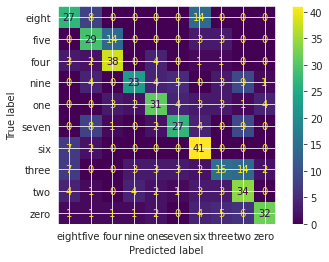

In [28]:
## Scaled Naive Bayes
self_recorded_pred_scaled = gnb_scaled.predict(self_recorded_scaled_features)

# Confusion Matrix
plot_confusion_matrix(gnb_scaled, self_recorded_scaled_features, self_recorded_target, values_format='d')

# Classification Report
self_recorded_scaled_report = classification_report(self_recorded_target, self_recorded_pred_scaled)
print(self_recorded_scaled_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       eight       1.00      0.06      0.12        49
        five       0.33      0.02      0.04        49
        four       0.55      0.45      0.49        49
        nine       0.00      0.00      0.00        49
         one       0.24      0.92      0.38        51
       seven       1.00      0.16      0.27        51
         six       0.00      0.00      0.00        50
       three       0.05      0.02      0.03        49
         two       0.19      0.85      0.31        52
        zero       0.75      0.06      0.11        53

    accuracy                           0.26       502
   macro avg       0.41      0.25      0.17       502
weighted avg       0.41      0.26      0.18       502



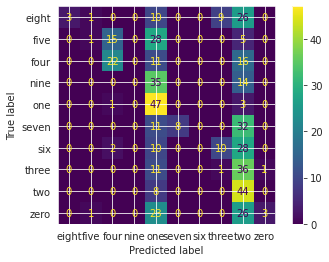

In [31]:
# No scaled
gnb_self_recorded_pred = gnb.predict(self_recorded_features)

# Confusion Matrix
plot_confusion_matrix(gnb, self_recorded_features, self_recorded_target)

# Classification Report
gnb_self_recorded_report = classification_report(self_recorded_target,gnb_self_recorded_pred)
print(gnb_self_recorded_report)

#### Random Forest

              precision    recall  f1-score   support

       eight       0.61      0.55      0.58        49
        five       0.77      0.41      0.53        49
        four       0.38      0.88      0.53        49
        nine       0.68      0.57      0.62        49
         one       0.47      0.69      0.56        51
       seven       0.94      0.57      0.71        51
         six       1.00      0.30      0.46        50
       three       0.40      0.35      0.37        49
         two       0.41      0.69      0.51        52
        zero       0.74      0.38      0.50        53

    accuracy                           0.54       502
   macro avg       0.64      0.54      0.54       502
weighted avg       0.64      0.54      0.54       502



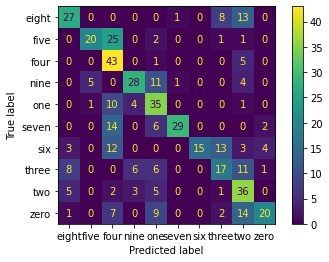

In [ ]:
rfc_self_recorded_pred = best_rfc.predict(self_recorded_features)

# Matriz de confusión
plot_confusion_matrix(best_rfc, self_recorded_features, self_recorded_target)

print(classification_report(self_recorded_target, rfc_self_recorded_pred))

#### Gradient Boosting

              precision    recall  f1-score   support

       eight       0.71      0.61      0.66        49
        five       0.73      0.39      0.51        49
        four       0.47      0.78      0.58        49
        nine       0.84      0.65      0.74        49
         one       0.57      0.71      0.63        51
       seven       0.96      0.43      0.59        51
         six       0.90      0.38      0.54        50
       three       0.36      0.47      0.41        49
         two       0.38      0.81      0.51        52
        zero       0.72      0.43      0.54        53

    accuracy                           0.57       502
   macro avg       0.66      0.57      0.57       502
weighted avg       0.66      0.57      0.57       502



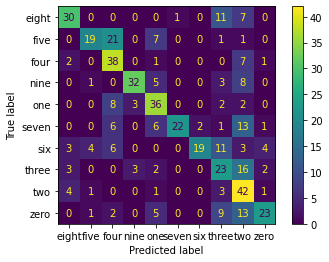

In [ ]:
gbm_self_recorded_pred = best_gbm.predict(self_recorded_features)

# Matriz de confusión
plot_confusion_matrix(best_gbm, self_recorded_features, self_recorded_target)

print(classification_report(self_recorded_target, gbm_self_recorded_pred))

# Plots

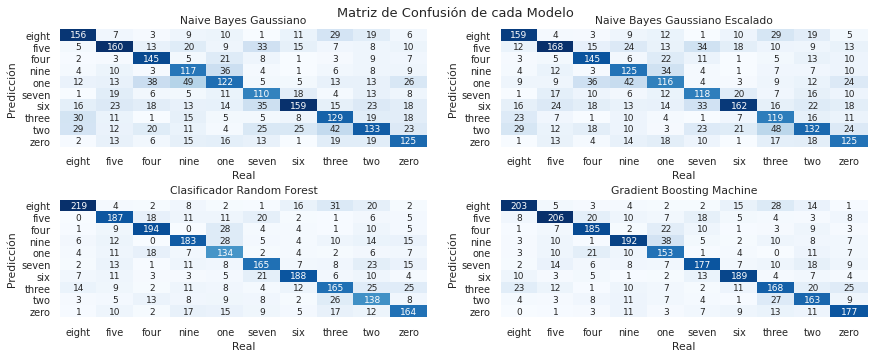

In [ ]:
matplotlib.rcParams['figure.figsize'] = [12, 5]
sns.set(font_scale=.9)#for label size

fig, axs = plt.subplots(2, 2,)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
fig.subplots_adjust(wspace=.2, hspace=.45)

def plot_confusion(model,x_test,y_test,ax,label=''):
    c = confusion_matrix(model.predict(x_test), y_test)
    df_cm = pd.DataFrame(c, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Predicción'
    df_cm.columns.name = 'Real'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 9}, cbar=False, fmt='g',ax=ax)# font size
    ax.set_title(label)

plot_confusion(gnb,x_test,y_test,axs[0,0],'Naive Bayes Gaussiano')
plot_confusion(gnb_scaled,x_test_scaled,y_test,axs[0,1],'Naive Bayes Gaussiano Escalado')
plot_confusion(best_rfc,x_test,y_test,axs[1,0],'Clasificador Random Forest')
plot_confusion(best_gbm,x_test,y_test,axs[1,1],'Gradient Boosting Machine')

fig.suptitle('Matriz de Confusión de cada Modelo')

plt.savefig('confusion_test.png')